### Task 7

### Import required libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

from skimage.morphology import skeletonize
from skimage.morphology import remove_small_objects
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph
from scipy.sparse import csr_matrix

### Display one plant

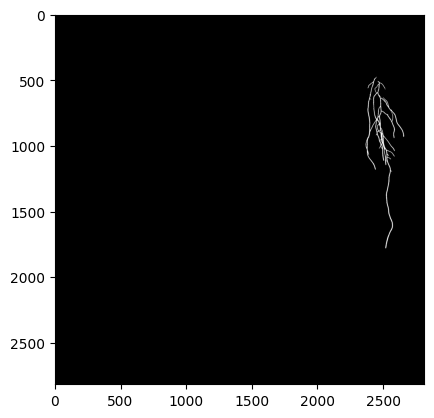

In [3]:
image = "Kaggle Plants 5/test_image_18_root_mask_plant_5.png"
plant_image = cv2.imread(image, 0)
plt.imshow(plant_image, cmap='gray')

## Code Overview: Root System Architecture (RSA) Extraction

This code calculates the main root length of a plant from a binary root mask image using skeletonization and graph-based analysis.

### Key Steps:
1. **Input Validation**:
   - Ensures the input image is valid.
   - Handles cases where the image is completely black by returning a distance of 0.

2. **Image Preprocessing**:
   - Converts the input to a binary image using thresholding.
   - Skeletonizes the binary image to reduce the root structure to a single-pixel-wide representation.

3. **Graph Analysis**:
   - Converts the skeletonized image into a graph representation.
   - Identifies the first and last nodes (endpoints of the root).

4. **Main Root Length Calculation**:
   - Computes the Euclidean distance between the first and last nodes, representing the main root length.

5. **Output**:
   - Returns the main root length and the coordinates of the first node.

### Example Usage:
The code reads a grayscale root mask image and calculates the main root length. If the image cannot be loaded, it logs an error. 

This function is particularly useful for analyzing plant root systems in agricultural or biological research.


In [4]:
import cv2
import os


def rsa_extraction(plant_image):
    if plant_image is None:
        raise ValueError("Input image is None. Check if the file path is correct and the image is valid.")

    # Check if the image is completely black
    if np.sum(plant_image) == 0:
        print("Input image is completely black. Returning distance = 0.")
        return 0

    _, binary_image = cv2.threshold(plant_image, 0, 255, cv2.THRESH_BINARY)

    binary_normalized = binary_image / 255
    plant_skeleton = skeletonize(binary_normalized).astype(np.uint8) * 255  
       
    # Assuming plant_image is your binary skeleton image
    g0, c0 = skeleton_to_csgraph(plant_skeleton)

    # Convert the coordinate array for processing
    coordinates = np.transpose(c0)

    # Get the first and last nodes
    first_node = coordinates[0]
    last_node = coordinates[-1]

    # Calculate the Euclidean distance between the first and last nodes
    distance = np.sqrt((last_node[0] - first_node[0])**2 + (last_node[1] - first_node[1])**2)

    return distance, tuple(first_node)

# Example usage
plant_path = "Kaggle Plants 5/test_image_1_root_mask_plant_5.png"
plant = cv2.imread(plant_path, 0)  # Load in grayscale
if plant is None:
    print(f"Failed to load image from path: {plant_path}")
else:
    main_root_length = rsa_extraction(plant)
    print(f"The main root length is: {main_root_length:.2f}")

Input image is completely black. Returning distance = 0.
The main root length is: 0.00


## Code Overview: Root System Architecture (RSA) Extraction

This code calculates the main root length of a plant from a binary root mask image using skeletonization and graph-based analysis.

### Key Steps:
1. **Input Validation**:
   - Ensures the input image is valid.
   - Handles cases where the image is completely black by returning a distance of 0.

2. **Image Preprocessing**:
   - Converts the input to a binary image using thresholding.
   - Skeletonizes the binary image to reduce the root structure to a single-pixel-wide representation.

3. **Graph Analysis**:
   - Converts the skeletonized image into a graph representation.
   - Identifies the first and last nodes (endpoints of the root).

4. **Main Root Length Calculation**:
   - Computes the Euclidean distance between the first and last nodes, representing the main root length.

5. **Output**:
   - Returns the main root length and the coordinates of the first node.

### Example Usage:
The code reads a grayscale root mask image and calculates the main root length. If the image cannot be loaded, it logs an error. 

This function is particularly useful for analyzing plant root systems in agricultural or biological research.


In [10]:
# function to process all images in a folder
def process_images_in_folder(folder_path, output_csv, tips_csv):
    # Initialize lists to store results
    results = []
    tips = []
    # Get a sorted list of image file paths
    image_files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))]
    )

    # Group images by "larger image" identifier (e.g., test_image_8)
    grouped_images = {}
    # fot loop to extract group identifier and plant number
    for filename in image_files:
        # Extract group identifier (e.g., test_image_8) and plant number
        base_name = os.path.splitext(filename)[0]
        parts = base_name.split('_')
        group_id = '_'.join(parts[:3])  # Extract "test_image_8"
        plant_num = int(parts[-1].replace("plant", ""))  # Extract "5" from "plant_5"
        # Add the image to the corresponding group
        if group_id not in grouped_images:
            grouped_images[group_id] = []
        grouped_images[group_id].append((plant_num, filename))

    # Sort groups and their images
    for group_id in grouped_images:
        grouped_images[group_id] = sorted(grouped_images[group_id], key=lambda x: x[0])

    # Process each group
    for group_id, plants in grouped_images.items():
        processed_plants = {plant_num: filename for plant_num, filename in plants}
        # fpr loop to process each plant
        for i in range(1, 6):  # Expecting exactly 5 plants
            # Check if the image exists for this plant
            if i in processed_plants:
                # Image exists for this plant
                filename = processed_plants[i]
                # Load the image    
                plant_path = os.path.join(folder_path, filename)
                plant_image = cv2.imread(plant_path, 0)  # Load the image in grayscale
                # check if the image is loaded
                if plant_image is None:
                    print(f"Skipping {filename}: Unable to load image.")
                    length = 0
                else:
                    # try catch block to handle exceptions
                    try:
                        length, tip = rsa_extraction(plant_image)
                    except Exception as e:
                        print(f"Error processing {filename}: {e}")
                        length = 0
                        tip = (0, 0)
                # Append the results
                formatted_name = f"{group_id}_plant_{i}"
                results.append({"Plant ID": formatted_name, "Length (px)": length})
                tips.append({"Plant ID": formatted_name, "Tip (px)": tip})
            # If the image is missing
            else:
                # Plant image missing, assign length 0
                formatted_name = f"{group_id}_plant_{i}.png"
                results.append({"Plant ID": formatted_name, "Length (px)": 0})
                tips.append({"Plant ID": formatted_name, "Tip (px)": tip})

    # Sort results by Plant ID numerically
    results = sorted(
        results,
        key=lambda x: (int(x['Plant ID'].split('_')[2]), int(x['Plant ID'].split('_')[4].replace("plant", "").replace(".png", "")))
    )
    # Sort tips by Plant ID numerically for Root Tips Coordinates
    tips = sorted(
        tips,
        key=lambda x: (int(x['Plant ID'].split('_')[2]), int(x['Plant ID'].split('_')[4].replace("plant", "").replace(".png", "")))
    )

    # Save the results to a CSV file
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")
    # Save the results to a CSV file for root tips
    df1 = pd.DataFrame(tips)
    df1.to_csv(tips_csv, index=False)
    print(f"Results saved to {tips_csv}")




# Specify the folder containing images and the output CSV file path
folder_path = "Kaggle Plants 5"  # Replace with the folder path
output_csv = "main_root_lengths_iteration_5.csv"
tips_csv = 'Root Tips-plates.csv'
# Process the images and save results to CSV
process_images_in_folder(folder_path, output_csv, tips_csv)

Input image is completely black. Returning distance = 0.
Error processing test_image_16_root_mask_plant_3.png: cannot unpack non-iterable int object
Input image is completely black. Returning distance = 0.
Error processing test_image_18_root_mask_plant_3.png: cannot unpack non-iterable int object
Input image is completely black. Returning distance = 0.
Error processing test_image_1_root_mask_plant_2.png: cannot unpack non-iterable int object
Input image is completely black. Returning distance = 0.
Error processing test_image_1_root_mask_plant_4.png: cannot unpack non-iterable int object
Input image is completely black. Returning distance = 0.
Error processing test_image_1_root_mask_plant_5.png: cannot unpack non-iterable int object
Results saved to main_root_lengths_iteration_dddd.csv
Results saved to Root Tips.csv
